In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Specify dtype option on import or set low_memory=False.
pd.options.mode.chained_assignment = None  # default='warn'

import math
import scipy

# Datviz purposes
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import missingno as msno

import tensorflow as tf
from tensorflow import keras

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

from sklearn.model_selection import train_test_split

In [2]:
try :
    train_data = pd.read_csv("/kaggle/input/joints-cleaned/train_data.csv")
    test_data = pd.read_csv("/kaggle/input/joints-cleaned/test_data.csv")
    submission_sample_data = pd.read_csv("/kaggle/input/joints-cleaned/sample_submission.csv") # For Kaggle

except :
    train_data = pd.read_csv("../4-FeatureEng/train_data.csv", low_memory=False)
    test_data = pd.read_csv("../4-FeatureEng/test_data.csv", low_memory=False) # For local

In [3]:
submission_sample_data.shape

(242082, 2)

## One-hot encoding

In [ ]:
# Change into one-hot encoding

# land_surface_condition	object	3
# type_of_foundation	object	5
# type_of_roof	object	3
# type_of_ground_floor	object	5
# type_of_other_floor	object	4
# position	int64	4
# building_plan_configuration	object	10
# type_of_reinforcement_concrete	int64	4
# residential_type	object	6
# public_place_type	object	6
# industrial_use_type	object	9
# govermental_use_type	object	3
# wall_binding	int64	6
# wall_material	int64	4

one_hot = ['land_surface_condition', 'type_of_foundation', 
           'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor', 
           'building_plan_configuration', 'residential_type', 'public_place_type', 
           'industrial_use_type', 'govermental_use_type', 'wall_binding', 'wall_material']

train_data = pd.get_dummies(train_data, columns=one_hot)
test_data = pd.get_dummies(test_data, columns=one_hot)

In [4]:
# copying the original dataset into X
X=train_data.copy()
# droping building_id and dependent variable damage_grade
# independant variables
X=X.drop(["damage_grade"],axis=1)
# dependent variable
y=train_data["damage_grade"]

In [5]:
# rf = RandomForestClassifier()
# param = {'n_estimators': [10, 150, 300],
#         'max_depth': [30, 60, 90, None]}

# gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
# gs_fit = gs.fit(X, y)
# pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

In [6]:
x_train, x_test,y_train, y_test = train_test_split(X,y,test_size = 0.30,random_state = 42)

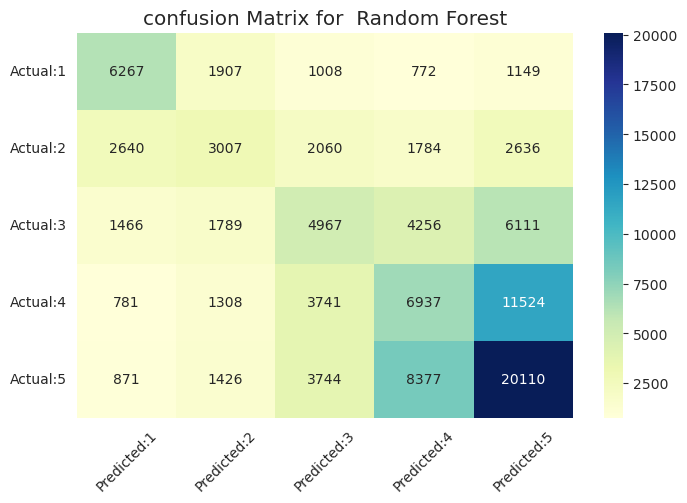

In [7]:
rf = RandomForestClassifier(n_estimators = 500,random_state = 1, max_depth=None,n_jobs=-1)
rf.fit(x_train,y_train)
rf_pred=rf.predict(x_test)
cm=confusion_matrix(y_test,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2',
                                          'Predicted:3','Predicted:4','Predicted:5',],
                                         index=['Actual:1','Actual:2',
                                                'Actual:3','Actual:4','Actual:5'])
                                                                            
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.title("confusion Matrix for  Random Forest")
plt.xticks(rotation=45)
plt.yticks(rotation=360)
plt.show()

In [8]:
print("-"*100)
print("Accuracy Score for Random Forest :",accuracy_score(y_test,rf_pred))
print("-"*100)
print("\n")
print("classification report for Random Forest :\n\n",classification_report(y_test, rf_pred))
print("-"*100)

----------------------------------------------------------------------------------------------------
Accuracy Score for Random Forest : 0.4102625250899263
----------------------------------------------------------------------------------------------------


classification report for Random Forest :

               precision    recall  f1-score   support

           1       0.52      0.56      0.54     11103
           2       0.32      0.25      0.28     12127
           3       0.32      0.27      0.29     18589
           4       0.31      0.29      0.30     24291
           5       0.48      0.58      0.53     34528

    accuracy                           0.41    100638
   macro avg       0.39      0.39      0.39    100638
weighted avg       0.40      0.41      0.40    100638

----------------------------------------------------------------------------------------------------


In [ ]:
# 

In [9]:
# now predicting on test_data dataset
test_data=test_data.drop("id",axis=1)
rf_pred_test_data=rf.predict(test_data)

In [10]:
submission_sample_data=submission_sample_data.drop("damage_grade",axis=1)
rf_pred_test_data=pd.DataFrame(rf_pred_test_data)
submission_sample_data["damage_grade"]=rf_pred_test_data
submission_sample_data.head()

,id,damage_grade
0,0,5
1,1,5
2,2,5
3,3,4
4,4,2


In [11]:
submission_sample_data.shape

(242082, 2)

In [12]:
submission_sample_data.to_csv('submission.csv', index=False)